In [1]:
#| default_exp inverse_design_local_generator

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
#| exporti

from inverse_design.inverse_design import *
from inverse_design.brushes import notched_square_brush
from inverse_design.naive_inverse_design import (
    viz_sim, mode_overlap, mask_combine_epsr
)
from inverse_design.conditional_generator import (
    new_latent_design, transform
)
from tqdm.notebook import trange
from jax.example_libraries.optimizers import adam

In [4]:
#| exporti

import jax
import jax.numpy as jnp
from javiche import jaxit
import matplotlib.pylab as plt
import numpy as np
from inverse_design.local_generator import generate_feasible_design_mask

> This notebook overwrites the inverse design notebook to use the local_generator

## Prepare

In [5]:
brush = notched_square_brush(5, 1)
latent = new_latent_design((Nx, Ny), r=1)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


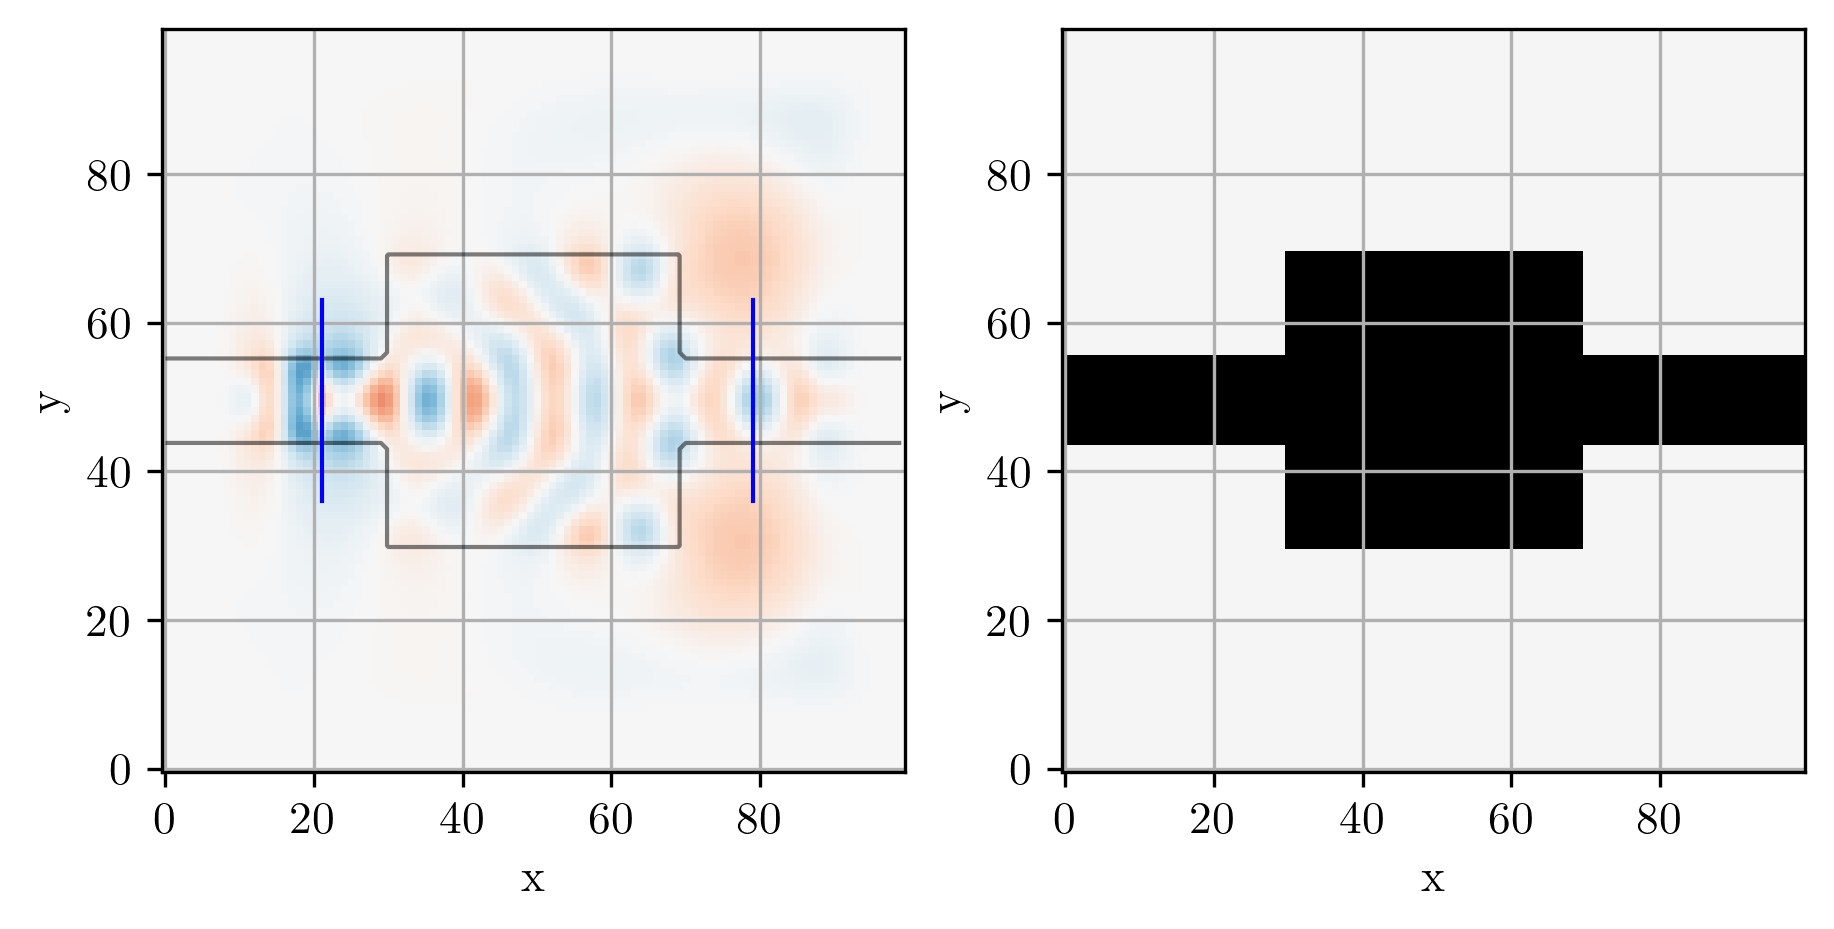

In [6]:
# Simulate initial device
simulation, ax = viz_sim(epsr_total, source, slices=[input_slice, output_slice])
_, _, Ez = simulation.solve(source)
E0 = mode_overlap(Ez, probe)

## Optimization

In [7]:
from inverse_design.local_generator import dilate

In [8]:
bg_mask = np.logical_or(bg_epsr>2, design_region)
eroded = dilate(np.logical_not(bg_mask), brush)
dilated = dilate(bg_epsr>2, brush)

init_t_s = np.logical_not(np.logical_or(eroded, design_region)) 
init_t_v = np.logical_not(np.logical_or(dilated, design_region)) 
# plt.imshow(init_t_s, vmax=1, vmin=0)
# plt.figure()
# plt.imshow(init_t_v, vmax=1, vmin=0)

In [9]:
latent_t = transform(latent, brush)
generate_feasible_design_mask(latent_t, brush) #, init_touches_solid=init_t_s.copy(), init_touches_void=init_t_v.copy(), verbose=True)

evaluating fn


Array([[ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1., -1., ...,  1.,  1.,  1.],
       ...,
       [ 1.,  1.,  1., ..., -1., -1., -1.],
       [ 1.,  1.,  1., ..., -1., -1., -1.],
       [ 1.,  1.,  1., ..., -1., -1., -1.]], dtype=float32)

In [34]:
def forward(latent_weights, brush):
    latent_t = transform(latent_weights, brush) #.reshape((Nx, Ny))
    design_mask = generate_feasible_design_mask(latent_t, 
      brush) #, init_touches_solid=init_t_s, init_touches_void=init_t_v, verbose=False
    epsr = (design_mask+1.0)/2.0*(12-1) +1 
    # complicated expression to avoid where clause, as it caused problems with differentiation
    return epsr

In [35]:
@jaxit()
def inner_loss_fn(epsr):
    simulation.eps_r = mask_combine_epsr(epsr, bg_epsr, design_region)
    _, _, Ez = simulation.solve(source)
    return -mode_overlap(Ez, probe) / E0

def loss_fn(latent):
    epsr = forward(latent, brush)
    return inner_loss_fn(epsr)

In [36]:
grad_fn = jax.jacfwd(generate_feasible_design_mask)
grads = grad_fn(latent_t, brush)
assert grads.std() != 0

In [37]:
grad_fn = jax.jacfwd(forward)
grads = grad_fn(latent, brush)
assert grads.std() != 0

In [40]:
grad_fn = jax.value_and_grad(loss_fn)
loss, grad = grad_fn(latent)
assert grad.std() != 0
assert loss != 0

In [41]:
init_fn, update_fn, params_fn = adam(step_size)
state = init_fn(latent) #.flatten()

this is the optimization step:

In [45]:
def step_fn(step, state):
    latent = params_fn(state) # we need autograd arrays here...
    loss, grads = grad_fn(latent)
    optim_state = update_fn(step, grads, state)
    return loss, optim_state

we can now loop over the optimization:

In [46]:
range_ = trange(5)
for step in range_:
    loss, state = step_fn(step, state)
    range_.set_postfix(loss=float(loss))

  0%|          | 0/5 [00:00<?, ?it/s]

evaluating fn


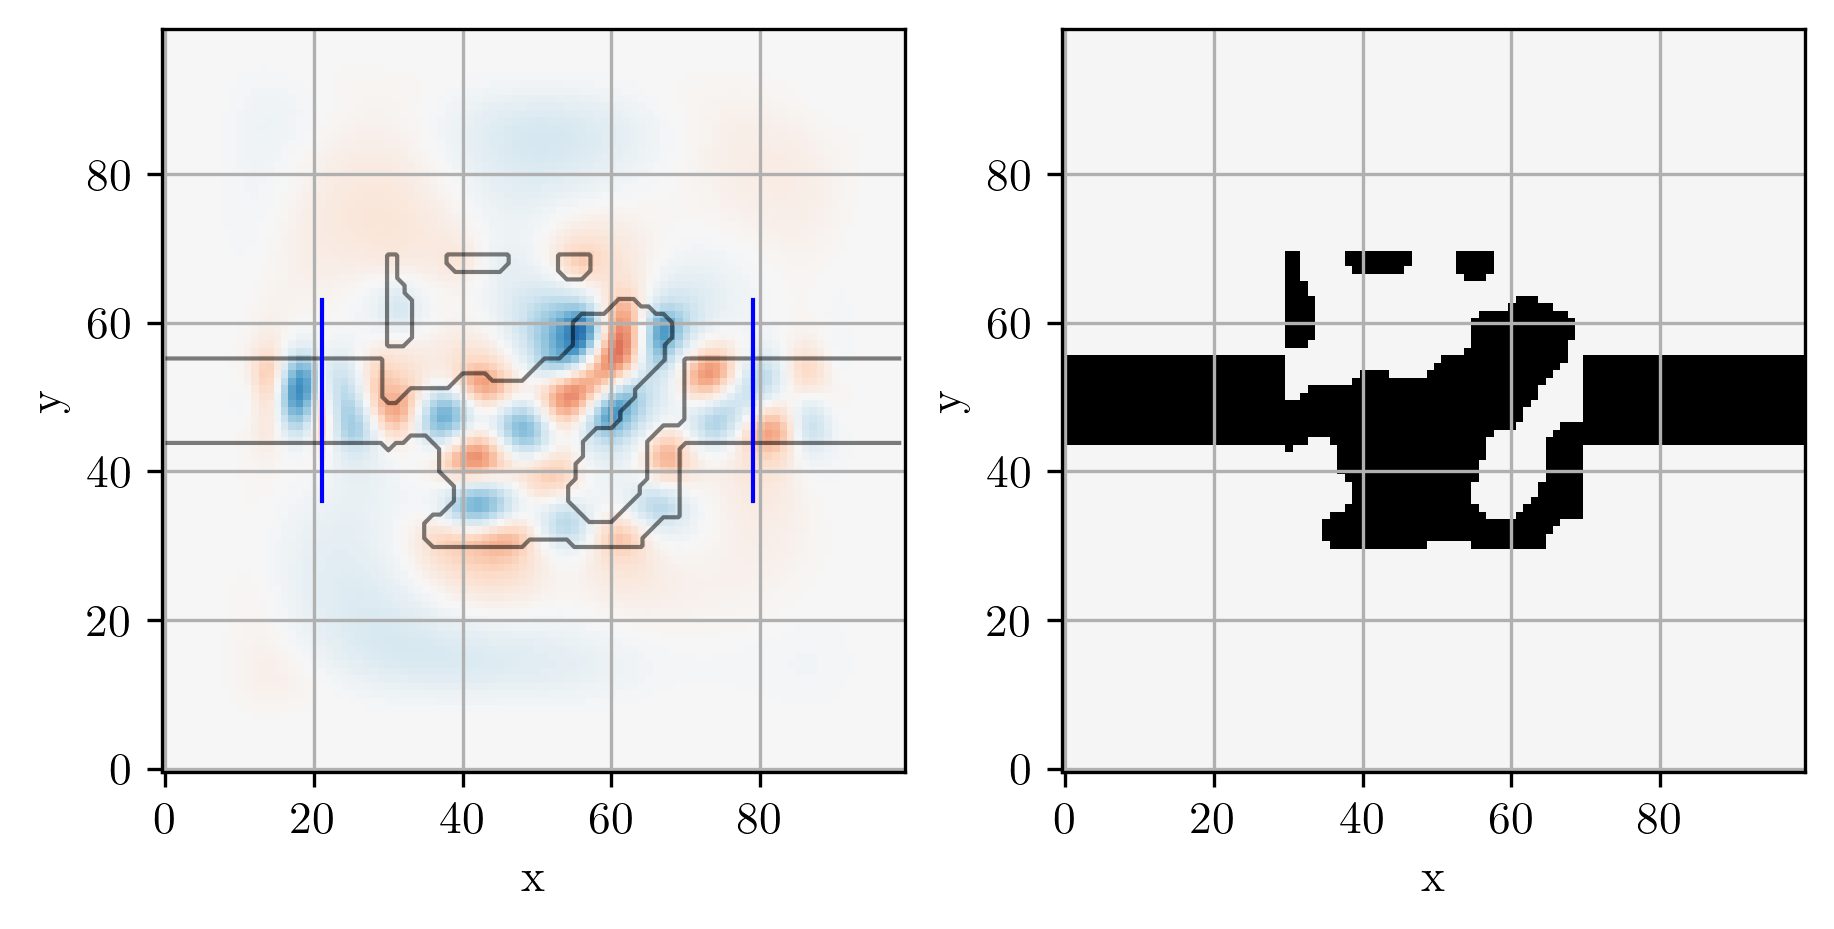

In [47]:
# Simulate and show the optimal device
epsr_optimum = forward(params_fn(state), brush)
epsr_optimum_total = mask_combine_epsr(epsr_optimum, bg_epsr, design_region)
simulation, ax = viz_sim(epsr_optimum_total, source, slices=[input_slice, output_slice])